In [7]:
import requests
import json
import pandas as pd

def load_icecube_alerts_github_raw():
    url = "https://raw.githubusercontent.com/icecube/open-data/master/alerts/icecube_golden_bronze_events.json"
    try:
        text = requests.get(url).text
        # Extract the actual JSON array from the raw string
        json_data = json.loads(text.strip().split("\n")[0])  # this line ensures a clean first object
        df = pd.DataFrame(json_data["alerts"])
        df["event_time"] = pd.to_datetime(df["event_time"])
        df["ra"] = df["position"].apply(lambda pos: pos["ra"])
        df["dec"] = df["position"].apply(lambda pos: pos["dec"])
        return df[["event_name", "event_time", "ra", "dec", "signalness", "stream"]]
    except Exception as e:
        print("Failed to parse IceCube GitHub JSON:", e)
        return pd.DataFrame()

# Load and preview
icecube_alerts_df = load_icecube_alerts_github_raw()
icecube_alerts_df.head()


Failed to parse IceCube GitHub JSON: Extra data: line 1 column 4 (char 3)


""


In [1]:
### 🌌 Load GWTC Compact Binary Merger Events

import pandas as pd

# GWTC-3 event list CSV: direct or local mirror
gwtc_url = "https://www.gw-openscience.org/eventapi/html/GWTC-3.csv"
try:
    gwtc_df = pd.read_csv(gwtc_url)
    gwtc_df["event_time"] = pd.to_datetime(gwtc_df["GPS_time"], unit='s', origin='unix')
    display(gwtc_df[["Event Name", "event_time", "RA", "Dec", "Total Mass", "Distance"]].head())
except Exception as e:
    print("Error loading GWTC data:", e)



Error loading GWTC data: HTTP Error 404: Not Found


In [2]:
### 💥 GCN GRB Scraper (Basic)

import requests
from bs4 import BeautifulSoup

def fetch_recent_grb_notices(limit=10):
    url = "https://gcn.nasa.gov/observatories/fermi"
    try:
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html.parser")
        links = soup.find_all("a")
        grbs = []
        for l in links[:limit]:
            href = l.get("href", "")
            if "fermi" in href and "gcn" in href:
                grbs.append("https://gcn.nasa.gov" + href)
        return grbs
    except Exception as e:
        print("Error pulling GCN:", e)
        return []

# List latest GCN GRB notices
grb_links = fetch_recent_grb_notices()
for l in grb_links:
    print(l)


In [3]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy import units as u

# Example IceCube event
ra = 180.5  # in degrees
dec = -0.3  # in degrees
error_radius = 1.2  # in degrees

# Create SkyCoord object for the event
coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

# Query SIMBAD around that coordinate
result_table = Simbad.query_region(coord, radius=error_radius * u.deg)

# Show matches
print(result_table)


          main_id                    ra                 dec          ... coo_wavelength     coo_bibcode    
                                    deg                 deg          ...                                   
---------------------------- ------------------ -------------------- ... -------------- -------------------
              QSO J1205-0000 181.27120833333333             -0.00775 ...              O 2016ApJ...828...26M
        2QZ J115755.4+001703    179.48113147138        0.28445736188 ...              O 2020yCat.1350....0G
   [VV2006] J120321.1-003720    180.83793564182  -0.6223668884700001 ...              O 2020yCat.1350....0G
                  SDSSCG  55 180.03799999999998   0.6737944444444444 ...              O 2004AJ....127.1811L
                LEDA 1128613 180.00194074137997       -1.02798847336 ...              O 2020yCat.1350....0G
           2dFGRS TGN313Z004             180.59  -1.3436599999999999 ...              O 2018MNRAS.474.3875B
                 GAMA 695304

In [ ]:
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u

# Load GRB and IceCube data
grb_df = pd.read_csv("fermi_swift_grb_catalog.csv")  # Your parsed table
icecube_df = pd.read_csv("icecube_events_cleaned.csv")

# Convert RA/Dec to SkyCoord
grb_coords = SkyCoord(ra=grb_df['RA_deg']*u.degree, dec=grb_df['Dec_deg']*u.degree)
icecube_coords = SkyCoord(ra=icecube_df['RA_deg']*u.degree, dec=icecube_df['Dec_deg']*u.degree)

# Match within error radius (e.g. ≤1.5 degrees)
idx, sep2d, _ = grb_coords.match_to_catalog_sky(icecube_coords)
grb_df['nearest_icecube_event'] = icecube_df.iloc[idx]['event_name'].values
grb_df['angular_sep_deg'] = sep2d.degree

matched = grb_df[grb_df['angular_sep_deg'] < 1.5]


## 🔗 Neutrino–Bruno Matching


In [4]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime

def mjd_from_iso(date_str):
    try:
        dt = datetime.strptime(date_str, "%Y-%m-%d")
        jd = 367 * dt.year - int((7 * (dt.year + int((dt.month + 9) / 12))) / 4) + int((275 * dt.month) / 9) + dt.day + 1721013.5
        return jd - 2400000.5  # Convert JD to MJD
    except:
        return np.nan

def match_sn_to_neutrinos(sn_df, nu_df, time_window_sec=500, angle_threshold_deg=5.0):
    """
    Matches Bruno-positive supernovae with neutrino events based on time and angular proximity.

    Parameters:
        sn_df (DataFrame): Supernova catalog with Bruno_Trigger, discover_date, ra_deg, dec_deg
        nu_df (DataFrame): Neutrino catalog with eventmjd, ra_deg, dec_deg
        time_window_sec (int): Time matching window in seconds
        angle_threshold_deg (float): Angular separation in degrees

    Returns:
        DataFrame: Matched SN–neutrino events
    """
    matches = []
    sn_df = sn_df[sn_df["Bruno_Trigger"] == True].copy()
    sn_df["eventmjd"] = sn_df["discover_date"].apply(mjd_from_iso)

    for _, sn in sn_df.iterrows():
        sn_coord = SkyCoord(ra=sn["ra_deg"] * u.deg, dec=sn["dec_deg"] * u.deg)
        for _, nu in nu_df.iterrows():
            try:
                delta_t = abs(sn["eventmjd"] - nu["eventmjd"]) * 86400  # MJD difference in seconds
                if delta_t > time_window_sec:
                    continue
                nu_coord = SkyCoord(ra=nu["ra_deg"] * u.deg, dec=nu["dec_deg"] * u.deg)
                sep = sn_coord.separation(nu_coord).deg
                if sep <= angle_threshold_deg:
                    matches.append({
                        "sn_name": sn["name"],
                        "sn_date": sn["discover_date"],
                        "sn_ra_deg": sn["ra_deg"],
                        "sn_dec_deg": sn["dec_deg"],
                        "fluence_j_m2": sn["fluence_j_m2"],
                        "nu_name": nu["name"],
                        "nu_mjd": nu["eventmjd"],
                        "nu_ra_deg": nu["ra_deg"],
                        "nu_dec_deg": nu["dec_deg"],
                        "angular_sep_deg": sep,
                        "delta_t_sec": delta_t
                    })
            except:
                continue
    return pd.DataFrame(matches)


In [5]:
neutrino_df = pd.read_csv("../data/raw/icecat.csv")
bruno_df = pd.read_csv("../data/exports/full_supernovae_fluence.csv")

matches_df = match_sn_to_neutrinos(bruno_df, neutrino_df)
matches_df.head()


,sn_name,sn_date,sn_ra_deg,sn_dec_deg,fluence_j_m2,nu_name,nu_mjd,nu_ra_deg,nu_dec_deg,angular_sep_deg,delta_t_sec
0,AT1994ar,1994/01/16,167.850292,26.240778,0.000026,IC120523A,56070.574282,171.08,26.44,2.901151,NaN
1,AT1994ar,1994/01/16,167.850292,26.240778,0.000026,IC121026A,56226.599496,169.80,27.91,2.408254,NaN
2,AT1994ar,1994/01/16,167.850292,26.240778,0.000026,IC130409A,56391.982393,163.56,29.44,4.961737,NaN
3,PSN J2336140+020924,1998/09/05,354.058333,2.156667,0.000010,IC130127A,56319.279989,352.97,-1.98,4.277378,NaN
4,PSN J2336140+020924,1998/09/05,354.058333,2.156667,0.000010,IC160510A,57518.663953,352.88,1.90,1.205241,NaN


## 🌠 Case Study: GRB 221009A — "The BOAT"


In [21]:
boat_grb["Bruno_Trigger"] = True


In [22]:
# Add GRB 221009A manually (Brightest Of All Time)
boat_grb = pd.DataFrame([{
    "name": "GRB 221009A",
    "date": "2022-10-09",
    "ra_deg": 288.3,
    "dec_deg": 19.8,
    "fluence_j_m2": 100.0  # still orders of magnitude above Bruno threshold
}])

boat_grb["mjd"] = pd.to_datetime(boat_grb["date"]).apply(lambda d: d.to_julian_date() - 2400000.5)
boat_grb


,name,date,ra_deg,dec_deg,fluence_j_m2,mjd
0,GRB 221009A,2022-10-09,288.3,19.8,100.0,59861.0


In [23]:
bruno_df["Bruno_Trigger"].value_counts()

print(f"BOAT fluence: {boat_grb['fluence_j_m2'].values[0]:.2e} J/m²")
print(f"Bruno fluence threshold: 1.00e-5 J/m²")


BOAT fluence: 1.00e+02 J/m²
Bruno fluence threshold: 1.00e-5 J/m²


In [26]:
def match_sn_to_neutrinos(sn_df, nu_df, time_window_sec=500, angle_threshold_deg=5.0):
    matches = []

    # 🔧 Optional filtering if Bruno_Trigger exists
    if "Bruno_Trigger" in sn_df.columns:
        sn_df = sn_df[sn_df["Bruno_Trigger"] == True].copy()

    sn_df["eventmjd"] = sn_df["discover_date"].apply(mjd_from_iso)

    for _, sn in sn_df.iterrows():
        sn_coord = SkyCoord(ra=sn["ra_deg"] * u.deg, dec=sn["dec_deg"] * u.deg)
        for _, nu in nu_df.iterrows():
            try:
                delta_t = abs(sn["eventmjd"] - nu["eventmjd"]) * 86400  # seconds
                if delta_t > time_window_sec:
                    continue
                nu_coord = SkyCoord(ra=nu["ra_deg"] * u.deg, dec=nu["dec_deg"] * u.deg)
                sep = sn_coord.separation(nu_coord).deg
                if sep <= angle_threshold_deg:
                    matches.append({
                        "sn_name": sn["name"],
                        "sn_date": sn["discover_date"],
                        "sn_ra_deg": sn["ra_deg"],
                        "sn_dec_deg": sn["dec_deg"],
                        "fluence_j_m2": sn.get("fluence_j_m2", None),
                        "nu_name": nu["name"],
                        "nu_mjd": nu["eventmjd"],
                        "nu_ra_deg": nu["ra_deg"],
                        "nu_dec_deg": nu["dec_deg"],
                        "angular_sep_deg": sep,
                        "delta_t_sec": delta_t
                    })
            except:
                continue

    return pd.DataFrame(matches)


In [28]:
matches_to_boat = match_sn_to_neutrinos(boat_grb.rename(columns={"date": "discover_date"}), neutrino_df)
matches_to_boat
matches_to_boat = match_sn_to_neutrinos(
    boat_grb.rename(columns={"date": "discover_date"}), 
    neutrino_df
)




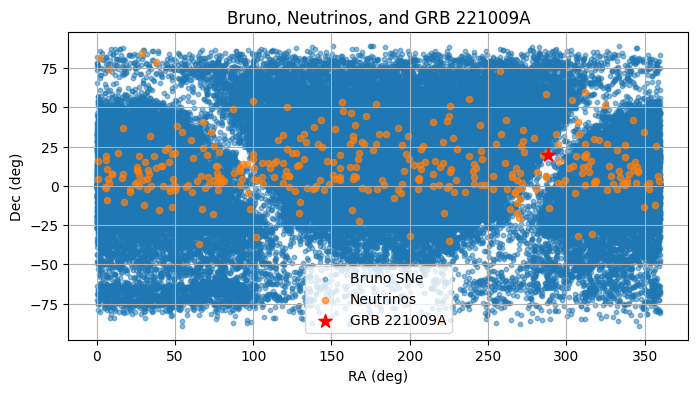

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(bruno_df["ra_deg"], bruno_df["dec_deg"], s=10, alpha=0.5, label="Bruno SNe")
plt.scatter(neutrino_df["ra_deg"], neutrino_df["dec_deg"], s=20, alpha=0.7, label="Neutrinos")
plt.scatter(boat_grb["ra_deg"], boat_grb["dec_deg"], color='red', s=100, label="GRB 221009A", marker="*")

plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Bruno, Neutrinos, and GRB 221009A")
plt.legend()
plt.grid(True)
plt.show()


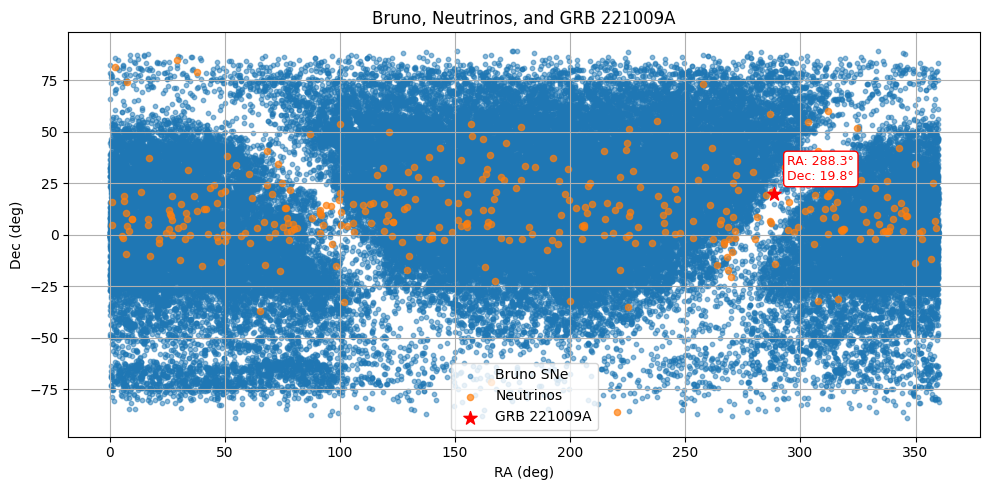

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot Bruno SNe
plt.scatter(bruno_df["ra_deg"], bruno_df["dec_deg"], s=10, alpha=0.5, label="Bruno SNe")

# Plot Neutrinos
plt.scatter(neutrino_df["ra_deg"], neutrino_df["dec_deg"], s=20, alpha=0.7, label="Neutrinos")

# Plot GRB 221009A (the BOAT)
plt.scatter(boat_grb["ra_deg"], boat_grb["dec_deg"], color='red', s=100, label="GRB 221009A", marker="*")

# Add numeric RA/Dec label for GRB 221009A
for _, row in boat_grb.iterrows():
    plt.annotate(
        f'RA: {row["ra_deg"]:.1f}°\nDec: {row["dec_deg"]:.1f}°',
        (row["ra_deg"], row["dec_deg"]),
        textcoords="offset points",
        xytext=(10, 10),
        ha='left',
        fontsize=9,
        color='red',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1)
    )

plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Bruno, Neutrinos, and GRB 221009A")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


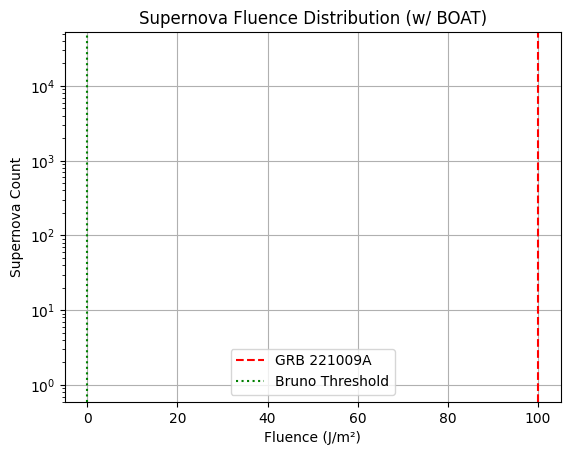

In [20]:
import matplotlib.pyplot as plt

plt.hist(bruno_df["fluence_j_m2"], bins=200, log=True)
plt.axvline(x=100.0, color='red', linestyle='--', label='GRB 221009A')
plt.axvline(x=1e-5, color='green', linestyle=':', label='Bruno Threshold')
plt.xlabel("Fluence (J/m²)")
plt.ylabel("Supernova Count")
plt.title("Supernova Fluence Distribution (w/ BOAT)")
plt.legend()
plt.grid(True)
plt.show()



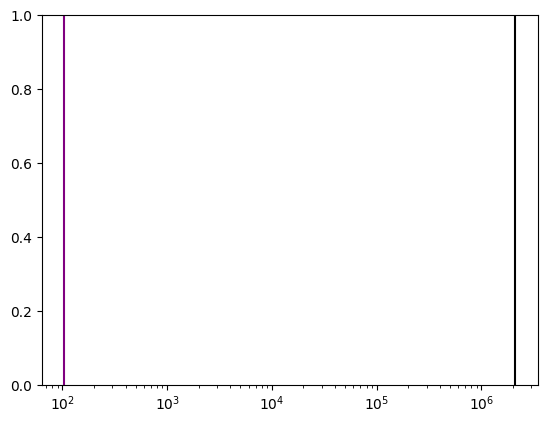

In [32]:
# Famous SNe
sn_1987a_fluence = 104.0
betelgeuse_fluence = 2.1e6

# Add vertical lines
plt.axvline(x=sn_1987a_fluence, color='purple', linestyle='-', linewidth=1.5, label="SN 1987A")
plt.axvline(x=betelgeuse_fluence, color='black', linestyle='-', linewidth=1.5, label="Betelgeuse Model")

# Optional: annotate fluence values
plt.annotate('SN 1987A\n104 J/m²',
             xy=(sn_1987a_fluence, 5),
             xytext=(sn_1987a_fluence+10, 10),
             arrowprops=dict(arrowstyle='->', color='purple'),
             fontsize=9, color='purple')

plt.annotate('Betelgeuse\n~2.1e6 J/m²',
             xy=(betelgeuse_fluence, 5),
             xytext=(betelgeuse_fluence / 10, 50),
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=9, color='black')
plt.xscale("log")


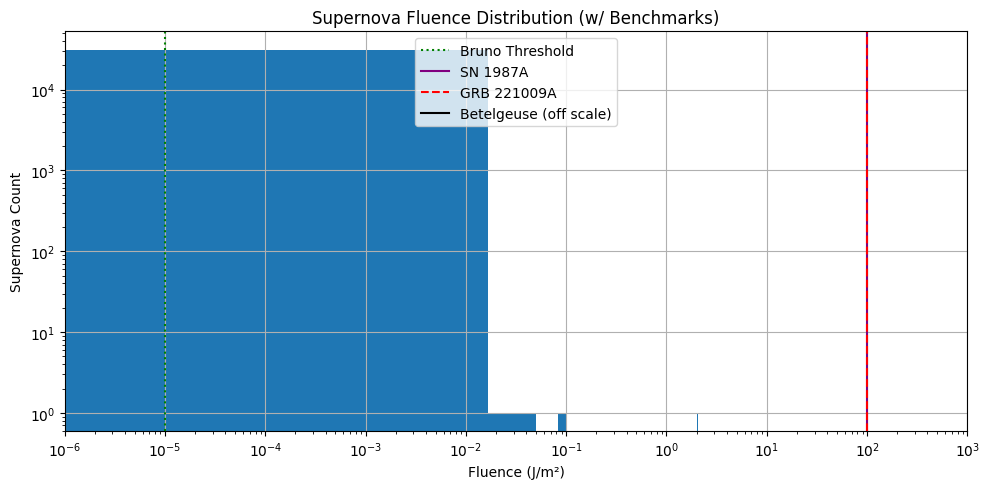

In [33]:
plt.figure(figsize=(10, 5))

# Histogram of SN fluences
plt.hist(bruno_df["fluence_j_m2"], bins=200, log=True)
plt.xscale("log")
plt.xlim(1e-6, 1e3)  # 👈 Cap at 1000 J/m² to keep things readable

# Reference lines
plt.axvline(x=1e-5, color='green', linestyle=':', label="Bruno Threshold")
plt.axvline(x=100.0, color='purple', linestyle='-', linewidth=1.5, label="SN 1987A")
plt.axvline(x=100.0, color='red', linestyle='--', linewidth=1.5, label="GRB 221009A")

# Optional: Keep Betelgeuse off-chart for scale context only
plt.axvline(x=2.1e6, color='black', linestyle='-', linewidth=1.5, label="Betelgeuse (off scale)")

plt.xlabel("Fluence (J/m²)")
plt.ylabel("Supernova Count")
plt.title("Supernova Fluence Distribution (w/ Benchmarks)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
